# Vancouver Crimes Brief Analysis (2003 - 2022).

This jupyter notebook is a brief analysis about the crimes registered by the Vancouver Police Department from 2003 to 2022.

## The brief analysis is still in progress.


In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
%matplotlib inline

In [2]:
crimes = pd.read_csv('CrimedataCSVAllNeighbourhoodsAllYears.csv')  

In [3]:
crimes.head()

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
0,Break and Enter Commercial,2012,12,14,8,52,NaN,Oakridge,491285.0000,5.453433e+06
1,Break and Enter Commercial,2019,3,7,2,6,10XX SITKA SQ,Fairview,490612.9648,5.457110e+06
2,Break and Enter Commercial,2019,8,27,4,12,10XX ALBERNI ST,West End,491007.7798,5.459174e+06
3,Break and Enter Commercial,2021,4,26,4,44,10XX ALBERNI ST,West End,491007.7798,5.459174e+06
4,Break and Enter Commercial,2014,8,8,5,13,10XX ALBERNI ST,West End,491015.9434,5.459166e+06


In [4]:
crimes.shape

(821413, 10)

In [5]:
crimes.isna().sum()

TYPE               0
YEAR               0
MONTH              0
DAY                0
HOUR               0
MINUTE             0
HUNDRED_BLOCK     12
NEIGHBOURHOOD    141
X                 72
Y                 72
dtype: int64

## This graphic presents the total amount of crimes in Vancouver by category.

In [6]:
grCrimes = crimes.groupby(['TYPE']).size().sort_values(ascending=False).reset_index(name="Count")

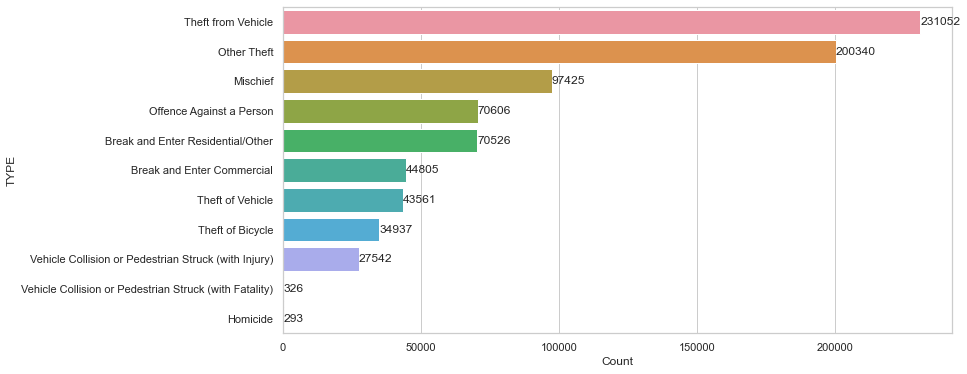

In [7]:
plt.figure(figsize=(12,6))
ax = sns.barplot(x="Count", y="TYPE", data=grCrimes)
ax.bar_label(ax.containers[0])
plt.show()

## This graphic presents the total amount of crimes committed in Vancouver by neighbourhood.

In [8]:
nbCrimes = crimes.groupby(['NEIGHBOURHOOD']).size().sort_values(ascending=False).reset_index(name="Count")

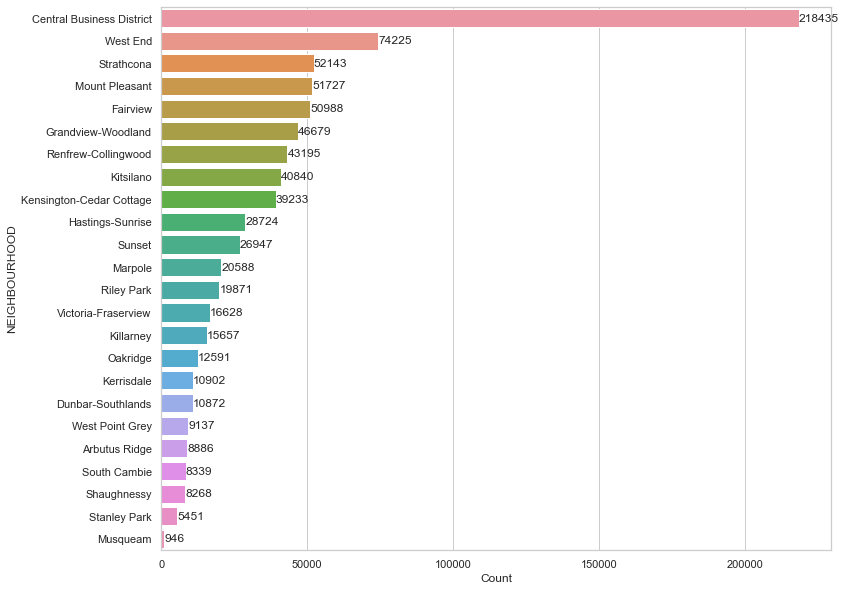

In [9]:
plt.figure(figsize=(12,10))
ax = sns.barplot(x="Count", y="NEIGHBOURHOOD", data=nbCrimes)
ax.bar_label(ax.containers[0])
plt.show()

## This graphic presents the total amount of crimes committed in Central Business District Vancouver neighbourhood by category.

In [10]:
dtCrimes = crimes.loc[(crimes['NEIGHBOURHOOD']=='Central Business District')].groupby(['TYPE']).size().\
                                                                    sort_values(ascending=False).reset_index(name="Count")

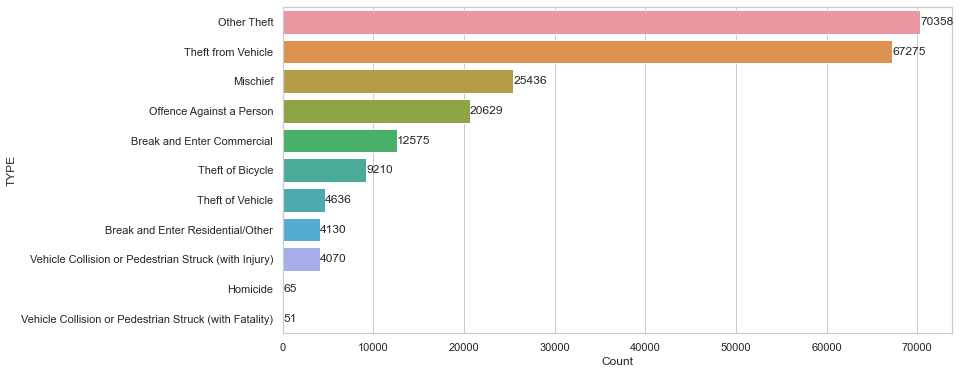

In [11]:
plt.figure(figsize=(12,6))
ax = sns.barplot(x="Count", y="TYPE", data=dtCrimes)
ax.bar_label(ax.containers[0])
plt.show()

## This graphic presents the temporal behavior of crimes committed in Vancouver from 2003 to 2021 by category.

In [12]:
tscrimes = crimes.loc[(crimes['YEAR']< 2022)].groupby(['TYPE','YEAR']).size().reset_index(name="Count")

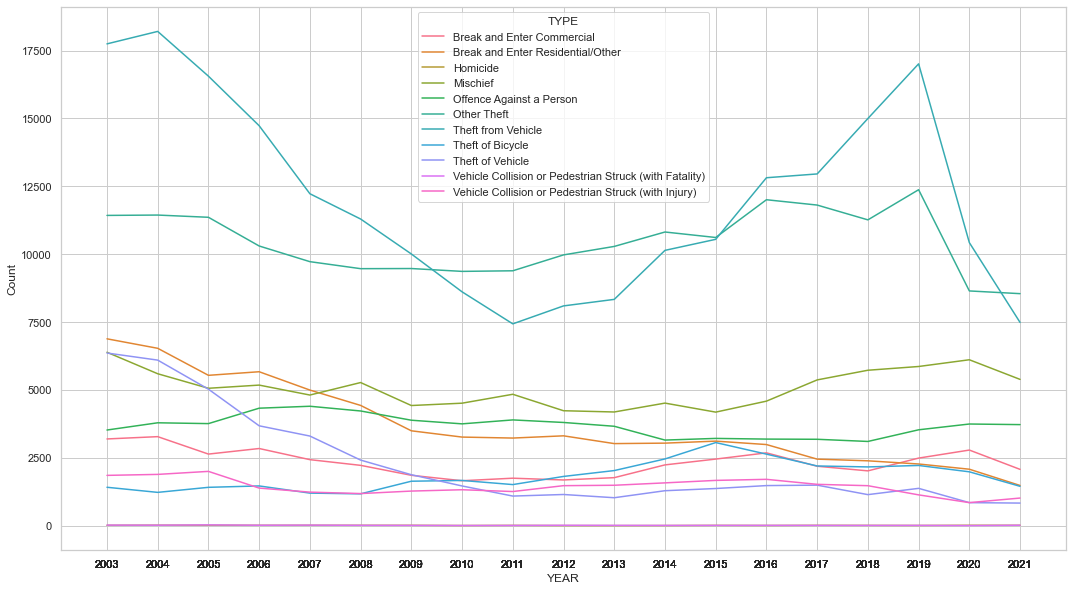

In [13]:
plt.figure(figsize=(18,10))
ax = sns.lineplot(data=tscrimes, x="YEAR", y="Count", hue="TYPE")
plt.xticks(tscrimes['YEAR'], rotation=0)
plt.show()

## This heatmap presents the behavior of Theft from Vehicle crimes in Vancouver Central Business District neighbourhood for each day of the weed and each hour of the day.

In [14]:
hourCrimes = crimes.loc[(crimes['TYPE'] == 'Theft from Vehicle') & (crimes['NEIGHBOURHOOD']=='Central Business District')]\
                                                                                            [['YEAR', 'MONTH', 'DAY', 'HOUR']]

hourCrimes['DATE'] = hourCrimes[['YEAR','MONTH','DAY']].\
                                  apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
hourCrimes['WEEKDAY'] =  hourCrimes['DATE'].apply(lambda x: pd.Timestamp(x).day_name())

In [15]:
heatCrimes = hourCrimes[['WEEKDAY','HOUR']].groupby(['WEEKDAY','HOUR']).size().reset_index(name="Count")
weekdays = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
heatCrimes['WEEKDAY'] = pd.Categorical(heatCrimes['WEEKDAY'],categories=weekdays)
heatCrimes = heatCrimes.sort_values('WEEKDAY')

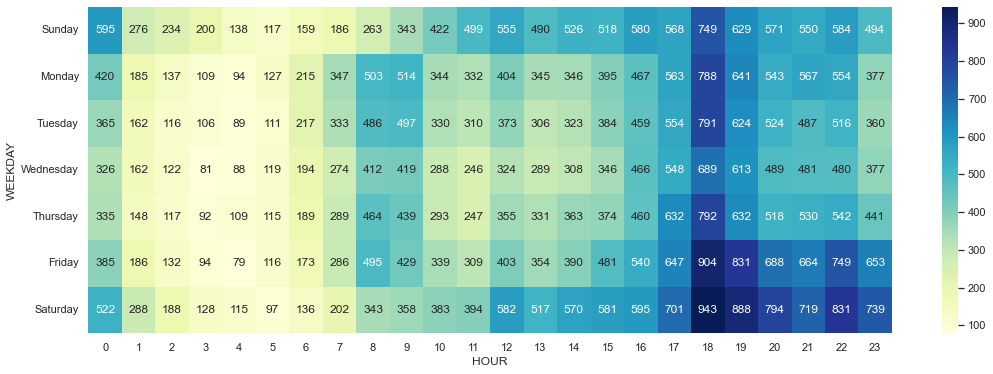

In [16]:
heatCrimesPivot = heatCrimes.pivot("WEEKDAY", "HOUR", "Count").sort_index(level=0, ascending=True)

plt.figure(figsize=(18,6))
ax = sns.heatmap(heatCrimesPivot, annot=True, fmt="d", cmap="YlGnBu")
plt.show()
